In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import basic library
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from os import listdir
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
DIRECTORY = "../input/patches/hpatches-release/"

In [4]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if 
               contains in f)

In [5]:
filenames = pd.DataFrame(list_files(DIRECTORY, "i_"))

df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames


In [6]:
filenames = pd.DataFrame(list_files(DIRECTORY, "v_"))

df2 = filenames[0].str.split(".", expand=True)
df2["filename"] = filenames

In [7]:
df = df.append(df2, ignore_index=True)

In [8]:
df=df.drop([0], axis=1)

In [9]:
df

,filename
0,i_yellowtent
1,i_toy
2,i_parking
3,i_village
4,i_brooklyn
...,...
111,v_vitro
112,v_pomegranate
113,v_graffiti
114,v_wormhole


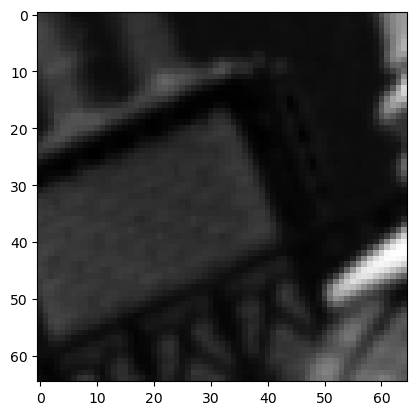

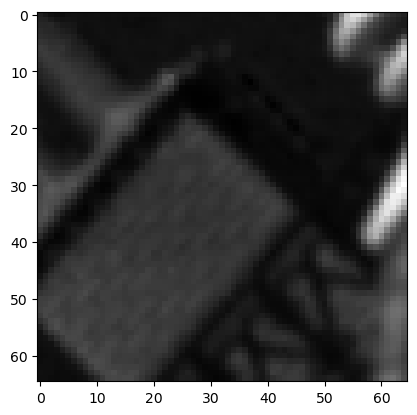

In [10]:
file_name=DIRECTORY+df["filename"][0]+"/e1.png"
a=plt.imread(file_name)
a=a[:65,:]
file_name1=DIRECTORY+df["filename"][0]+"/ref.png"
a1=plt.imread(file_name1)
a1=a1[:65,:]
plt.imshow(a,cmap='gray')
plt.show()
plt.imshow(a1,cmap='gray')
plt.show()


In [11]:
import json
  
# Opening JSON file
f = open("../input/splits/splits.json")
  
# returns JSON object as 
# a dictionary
data = json.load(f)

### Creating Model


In [236]:
model=nn.Sequential(nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(3,3),padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=2,padding=1,),
                    nn.BatchNorm2d(64),
                    nn.Sigmoid(),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),padding=1),
                    nn.BatchNorm2d(64),
                    nn.Sigmoid(),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=2,padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(8,8),padding=0)       
                   )

In [212]:
!pip install torch-summary

In [213]:
from torchsummary import summary
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            18,496
├─BatchNorm2d: 1-5                       128
├─Sigmoid: 1-6                           --
├─Conv2d: 1-7                            73,856
├─BatchNorm2d: 1-8                       256
├─ReLU: 1-9                              --
├─Dropout: 1-10                          --
├─Conv2d: 1-11                           1,048,704
Total params: 1,141,824
Trainable params: 1,141,824
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─BatchNorm2d: 1-2                       64
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            18,496
├─BatchNorm2d: 1-5                       128
├─Sigmoid: 1-6                           --
├─Conv2d: 1-7                            73,856
├─BatchNorm2d: 1-8                       256
├─ReLU: 1-9                              --
├─Dropout: 1-10                          --
├─Conv2d: 1-11                           1,048,704
Total params: 1,141,824
Trainable params: 1,141,824
Non-trainable params: 0

### Importing Data and making it suitable for training

In [15]:
pos=pd.read_csv("../input/splits/verif_pos_split-a.csv")
neg_intra=pd.read_csv("../input/splits/verif_neg_intra_split-a.csv")
neg_inter=pd.read_csv("../input/splits/verif_neg_inter_split-a.csv")

In [16]:
pos.head()

,s1,t1,idx1,s2,t2,idx2
0,v_birdwoman,4,251,v_birdwoman,3,251
1,v_strand,1,1625,v_strand,3,1625
2,i_salon,0,1100,i_salon,3,1100
3,i_zion,3,1766,i_zion,0,1766
4,v_courses,3,410,v_courses,1,410


In [17]:
neg_intra.head()

,s1,t1,idx1,s2,t2,idx2
0,v_birdwoman,4,251,v_birdwoman,3,1896
1,v_strand,1,1625,v_strand,3,1055
2,i_salon,0,1100,i_salon,3,585
3,i_zion,3,1766,i_zion,0,542
4,v_courses,3,410,v_courses,1,144


In [18]:
neg_inter.head()

,s1,t1,idx1,s2,t2,idx2
0,v_birdwoman,4,251,i_resort,3,204
1,v_strand,1,1625,i_santuario,3,482
2,i_salon,0,1100,i_ajuntament,3,544
3,i_zion,3,1766,i_brooklyn,0,848
4,v_courses,3,410,v_tabletop,1,1200


In [19]:
train_pos=pos.iloc[:900000,:]
train_neg_inter=neg_inter.iloc[:900000,:]
train_neg_intra=neg_intra.iloc[:900000,:]
test_pos=pos.iloc[900000:,:]
test_neg_inter=neg_inter.iloc[900000:,:]
test_neg_intra=neg_intra.iloc[900000:,:]

In [20]:
images={}
for i in df["filename"]:
    a=[]
    filename1="../input/patches/hpatches-release/"+i+'/'
    
    a.append(plt.imread(filename1+"e1.png"))
    a.append(plt.imread(filename1+"e2.png"))
    a.append(plt.imread(filename1+"e3.png"))
    a.append(plt.imread(filename1+"e4.png"))
    a.append(plt.imread(filename1+"e5.png"))
    
    images[i]=a
   

In [21]:
import time

In [22]:
start=time.time()
train_a=[]
train_p=[]
for i in range(100000):
    s1=train_pos.iloc[i]['s1']
    t1=train_pos.iloc[i]['t1']
    idx1=train_pos.iloc[i]['idx1']
#     filename1="../input/patches/hpatches-release/"+s1+"/"+"e"+str(t1)+".png"
    s2=train_pos.iloc[i]['s2']
    t2=train_pos.iloc[i]['t2']
    idx2=train_pos.iloc[i]['idx2']
#     filename2="../input/patches/hpatches-release/"+s1+"/"+"e"+str(t2)+".png"

    
    train_a.append(((images[s1][t1][idx1*65:idx1*65+65,:]*255).astype("int32")))
    train_p.append(((images[s2][t2][idx1*65:idx1*65+65,:]*255).astype("int32")))
    
    


train_n1=[]
train_n2=[]
for i in range(100000):
    s1=train_neg_inter.iloc[i]['s2']
    t1=train_neg_inter.iloc[i]['t2']
    idx1=train_neg_inter.iloc[i]['idx2']
#     filename1="../input/patches/hpatches-release/"+s1+"/"+"e"+str(t1)+".png"
    s2=train_neg_intra.iloc[i]['s2']
    t2=train_neg_intra.iloc[i]['t2']
    idx2=train_neg_intra.iloc[i]['idx2']
#     filename2="../input/patches/hpatches-release/"+s1+"/"+"e"+str(t2)+".png"
    
    train_n1.append(((images[s1][t1][idx1*65:idx1*65+65,:]*255).astype("int32")))
    train_n2.append(((images[s2][t2][idx2*65:idx2*65+65,:]*255).astype("int32")))
    

end=time.time()    
    

In [24]:
train_a=np.array(train_a)
train_p=np.array(train_p)
train_n1=np.array(train_n1)
train_n2=np.array(train_n2)



In [25]:
del images

In [26]:
from numpy import save
save('train_a.npy', train_a)
save('train_p.npy', train_p)
save('train_n1.npy', train_n1)
save('train_n2.npy', train_n2)

In [31]:
import cv2

In [33]:
train_a=train_a.astype("float32")
train_p=train_p.astype("float32")
train_n1=train_n1.astype("float32")
train_n2=train_n2.astype("float32")

In [298]:
k=np.load("../output/kaggle/working/train_n2.npy")

FileNotFoundError: [Errno 2] No such file or directory: '../output/kaggle/working/train_n2.npy'

In [37]:
p=[]
a=[]
n1=[]
n2=[]

In [38]:
for i in range(100000):
    a.append(cv2.resize(train_a[i],(32,32)))
    p.append(cv2.resize(train_p[i],(32,32)))
    n1.append(cv2.resize(train_n1[i],(32,32)))
    n2.append(cv2.resize(train_n2[i],(32,32)))
    
    

In [39]:
train_a=np.array(a)
train_p=np.array(p)
train_n1=np.array(n1)
train_n2=np.array(n2)

In [76]:
train_a=torch.tensor(train_a)

In [77]:
train_p=torch.tensor(train_p)
train_n1=torch.tensor(train_n1)
train_n2=torch.tensor(train_n2)

In [91]:
train_a=train_a.reshape((100000,1,32,32))
train_p=train_p.reshape((100000,1,32,32))
train_n1=train_n1.reshape((100000,1,32,32))
train_n2=train_n2.reshape((100000,1,32,32))

In [98]:
train_a=train_a/255
train_p=train_p/255
train_n1=train_n1/255
train_n2=train_n2/255

### Loss function and optimizer

In [228]:
def triplet_loss(a,p,n):
    alpha = 100
    a=a.reshape(-1,128)
    p=p.reshape(-1,128)
    n=n.reshape(-1,128)
    
    positive_distance = torch.mean(torch.square(a - p), axis=-1)
    negative_distance = torch.mean(torch.square(a - n), axis=-1)

#     return torch.sum(torch.maximum(torch.tensor(0.0), positive_distance - negative_distance + alpha))/(a.shape[0])
    return torch.sum(torch.maximum(torch.tensor(0.0),50-negative_distance))/a.shape[0], torch.sum(positive_distance)


In [260]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)

In [258]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─Conv2d: 1-5                            36,928
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─Conv2d: 1-8                            147,584
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           1,049,088
├─Linear: 1-11                           131,328
├─Linear: 1-12                           32,896
Total params: 1,499,744
Trainable params: 1,499,744
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─Conv2d: 1-5                            36,928
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─Conv2d: 1-8                            147,584
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           1,049,088
├─Linear: 1-11                           131,328
├─Linear: 1-12                           32,896
Total params: 1,499,744
Trainable params: 1,499,744
Non-trainable params: 0

### Creating Model

In [252]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Define the fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        # Pass input through the convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        # Flatten the feature maps and pass through fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [275]:
model=SiameseNetwork()

### Training Loop

In [269]:
num_epoch=50
index=np.arange(0,100000)
for epoch in range(num_epoch):
    perm = np.random.permutation(100000)
    train_a=train_a[perm]
    train_p=train_p[perm]
    train_n1=train_n1[perm]
    train_n2=train_n2[perm]
    for i in range(0,100000,256):
    
        output_a=model(train_a[i:i+32]*1000)
        output_p=model(train_p[i:i+32]*1000)
        output_n1=model(train_n1[i:i+32]*1000)
        output_n2=model(train_n2[i:i+32]*1000)
        loss1,loss2=triplet_loss(output_a,output_p,output_n1)
        
        loss=(loss1+loss2)/2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)
        
        
    
    
    

tensor(25.0111, grad_fn=<DivBackward0>)
tensor(25.0326, grad_fn=<DivBackward0>)
tensor(25.0217, grad_fn=<DivBackward0>)
tensor(25.0247, grad_fn=<DivBackward0>)
tensor(25.0209, grad_fn=<DivBackward0>)
tensor(25.0238, grad_fn=<DivBackward0>)
tensor(25.0148, grad_fn=<DivBackward0>)
tensor(25.0347, grad_fn=<DivBackward0>)
tensor(25.0335, grad_fn=<DivBackward0>)
tensor(25.0370, grad_fn=<DivBackward0>)
tensor(25.0361, grad_fn=<DivBackward0>)
tensor(25.0323, grad_fn=<DivBackward0>)
tensor(25.0266, grad_fn=<DivBackward0>)
tensor(25.0215, grad_fn=<DivBackward0>)
tensor(25.0156, grad_fn=<DivBackward0>)
tensor(25.0452, grad_fn=<DivBackward0>)
tensor(25.0196, grad_fn=<DivBackward0>)
tensor(25.0431, grad_fn=<DivBackward0>)
tensor(25.0232, grad_fn=<DivBackward0>)
tensor(25.0180, grad_fn=<DivBackward0>)
tensor(25.0460, grad_fn=<DivBackward0>)
tensor(25.0157, grad_fn=<DivBackward0>)
tensor(25.0222, grad_fn=<DivBackward0>)
tensor(25.0282, grad_fn=<DivBackward0>)
tensor(25.0269, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [61]:
import random

In [278]:
k=train_a[0:32,:]

In [294]:
t=train_a.numpy()

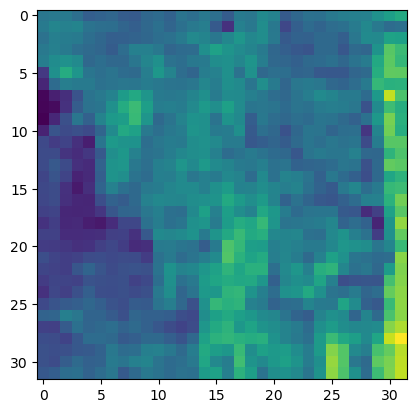

In [297]:
plt.imshow(t[0].reshape(32,32))

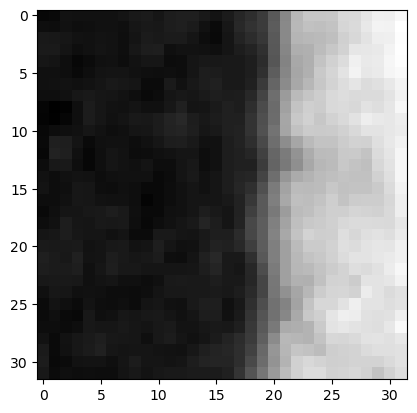

In [292]:
plt.imshow(k[8].numpy().reshape(32,32),cmap='gray')

In [277]:
torch.sum(model(train_p[2:3]*100000)-model(train_a[2:3]*100000))

tensor(124.3976, grad_fn=<SumBackward0>)

In [180]:
k

tensor([[[[-0.5683]],

         [[ 0.4936]],

         [[ 0.3996]],

         [[-0.0883]],

         [[ 0.0611]],

         [[ 0.0926]],

         [[ 1.1966]],

         [[-0.4755]],

         [[-0.2218]],

         [[ 0.3961]],

         [[ 1.0455]],

         [[-0.3236]],

         [[-0.1251]],

         [[ 0.6032]],

         [[-0.0951]],

         [[ 0.9455]],

         [[-1.0933]],

         [[-0.6443]],

         [[ 0.2909]],

         [[-0.1488]],

         [[-0.3216]],

         [[ 0.6275]],

         [[-0.4103]],

         [[-0.6367]],

         [[ 0.1116]],

         [[-0.2124]],

         [[-0.1764]],

         [[-0.4607]],

         [[-0.4267]],

         [[ 0.1899]],

         [[-0.1360]],

         [[-0.2654]],

         [[ 1.0047]],

         [[ 0.3274]],

         [[-0.1171]],

         [[ 0.8236]],

         [[-0.3222]],

         [[ 0.6918]],

         [[ 0.3402]],

         [[ 0.7972]],

         [[ 0.7900]],

         [[ 1.5322]],

         [[ 0.2439]],

         [[

In [135]:
k=k.reshape(-1,128)

In [136]:
torch.mean(k,axis=-1)

tensor([0.0046, 0.0037, 0.0039], grad_fn=<MeanBackward1>)

In [143]:
k=torch.tensor(np.array([-1,2,4]))

In [145]:
torch.sum(torch.maximum(torch.tensor(0),k))

tensor(6)